# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Bay-Area-population-during-the-day" data-toc-modified-id="Bay-Area-population-during-the-day-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Bay Area population during the day</a></div><div class="lev2 toc-item"><a href="#Merge-with-tracts-shapefile-of-population" data-toc-modified-id="Merge-with-tracts-shapefile-of-population-11"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Merge with tracts shapefile of population</a></div><div class="lev2 toc-item"><a href="#Visualize-it" data-toc-modified-id="Visualize-it-12"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Visualize it</a></div><div class="lev2 toc-item"><a href="#Save-data-as-GeoJSON-for-leaflet-web-map" data-toc-modified-id="Save-data-as-GeoJSON-for-leaflet-web-map-13"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Save data as GeoJSON for leaflet web map</a></div><div class="lev1 toc-item"><a href="#BONUS:-can-you-make-the-same-map-for-NYC-area?" data-toc-modified-id="BONUS:-can-you-make-the-same-map-for-NYC-area?-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>BONUS: can you make the same map for NYC area?</a></div>

# Bay Area population during the day

Tract-level daytime population measures as local population, plus population that works there, minus population that lives there but works elsewhere. Non-resident, non-working population is not accounted for (tourists, homeless, etc).

In [163]:
from __future__ import print_function
import numpy as np, pandas as pd, geopandas as gpd, matplotlib as plt, matplotlib.cm as cm 
from matplotlib.collections import PatchCollection
from descartes import PolygonPatch
from shapely.geometry import Polygon, MultiPolygon
import zipfile
import gzip
import shutil 
import csv
import os

In [165]:
import matplotlib.pyplot as plt
import shapely

In [2]:
# Grab data directly from the web!
# Download into a "download" folder to keep things clean
!wget http://www2.census.gov/geo/tiger/TIGER2010DP1/Tract_2010Census_DP1.zip -P ./download/
!wget http://cosmo.nyu.edu/~fb55/data/ca_od_main_JT00_2010.csv.gz -P ./download/
!wget http://www2.census.gov/geo/tiger/GENZ2010/gz_2010_us_040_00_500k.zip -P ./download/

--2017-03-03 14:12:28--  http://www2.census.gov/geo/tiger/TIGER2010DP1/Tract_2010Census_DP1.zip
Resolving www2.census.gov... 23.217.21.225, 2600:1400:d:386::208c, 2600:1400:d:39b::208c
Connecting to www2.census.gov|23.217.21.225|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 409901240 (391M) [application/zip]
Saving to: ‘./download/Tract_2010Census_DP1.zip’

Tract_2010Census_DP 100%[===================>] 390.91M  5.50MB/s    in 83s     

2017-03-03 14:13:51 (4.72 MB/s) - ‘./download/Tract_2010Census_DP1.zip’ saved [409901240/409901240]

--2017-03-03 14:13:52--  http://cosmo.nyu.edu/~fb55/data/ca_od_main_JT00_2010.csv.gz
Resolving cosmo.nyu.edu... 128.122.53.240
Connecting to cosmo.nyu.edu|128.122.53.240|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 81745043 (78M) [application/x-gzip]
Saving to: ‘./download/ca_od_main_JT00_2010.csv.gz’

ca_od_main_JT00_201 100%[===================>]  77.96M  5.16MB/s    in 16s     

2017-03-03 14:14:0

In [5]:
# Unzip
zf = zipfile.ZipFile('download/Tract_2010Census_DP1.zip')
zf.extractall('download/')
zf = zipfile.ZipFile('download/gz_2010_us_040_00_500k.zip')
zf.extractall('download/')
#zf = zipfile.ZipFile('download/ca_od_main_JT00_2010.csv.gz') 
#zf.extractall('download/')
f = gzip.open('download/ca_od_main_JT00_2010.csv.gz', mode="rt")

In [14]:
import gzip
with gzip.open('download/ca_od_main_JT00_2010.csv.gz', 'rb') as f:
    file_content = f.read()

In [24]:
with gzip.open('download/ca_od_main_JT00_2010.csv.gz', 'r') as fin, open('ca_od_main_JT00_2010.csv','w') as fout:
    csv_reader = csv.reader(fin)
    csv_writer = csv.writer(fout)
    csv_writer.writerows(csv_reader)

In [29]:
os.system("mkdir data")

0

In [30]:
# Move shapefiles and csv to data folder
#shutil.move('download/gz_2010_us_040_00_500k.dbf', 'data/')

In [37]:
#shutil.move('download/gz_2010_us_040_00_500k.prj', 'data/')
#shutil.move('download/gz_2010_us_040_00_500k.shp', 'data/')
#shutil.move('download/gz_2010_us_040_00_500k.shx', 'data/')
#shutil.move('download/gz_2010_us_040_00_500k.shx', 'data/')
#shutil.move('download/gz_2010_us_040_00_500k.xml', 'data/')
#shutil.move('ca_od_main_JT00_2010.csv', 'data/')


In [103]:
# CA's lodes: lehd origin-destination employment statistics (block-level)
# main file includes jobs with both workplace residence in the state
# jt00 is all job types
lodes_filepath = 'data/ca_od_main_JT00_2010.csv' #lodes data file
tracts_filepath = 'download/Tract_2010Census_DP1' #census tracts shapefile with pop data
states_filepath = 'data/gz_2010_us_040_00_500k' #states shapefile

In [70]:
def load_str(value):
    return str(value)
converters = {'w_geocode' : load_str,
              'h_geocode' : load_str}

# load the lodes data and preserve fips codes as strings bc of preceding zeros
lodes = pd.read_csv(lodes_filepath, converters=converters)

In [47]:
#lodes = pd.read_csv('data/ca_od_main_JT00_2010.csv')

In [71]:
# h_geocode is home residence block fips
# w_geocode is workplace block fips
# S000 is total number of jobs commuting from h_geocode to w_geocode
lodes.head()

,w_geocode,h_geocode,S000,SA01,SA02,SA03,SE01,SE02,SE03,SI01,SI02,SI03,createdate
0,060014001001000,060014001001015,1,0,1,0,0,0,1,0,0,1,20160229
1,060014001001000,060014001001036,1,0,1,0,0,0,1,0,0,1,20160229
2,060014001001000,060014001001044,1,0,0,1,0,0,1,0,0,1,20160229
3,060014001001000,060014001001047,1,1,0,0,1,0,0,0,1,0,20160229
4,060014001001000,060014002001004,1,0,0,1,1,0,0,0,0,1,20160229


In [ ]:
# extract home and work tract fips codes (first 11 digits) from the block fips codes

In [72]:
lodes['h_tract'] = lodes['h_geocode'].map(lambda x: x[:11]) 

In [73]:
lodes['w_tract'] = lodes['w_geocode'].map(lambda x: x[:11])

In [74]:
lodes.head()

,w_geocode,h_geocode,S000,SA01,SA02,SA03,SE01,SE02,SE03,SI01,SI02,SI03,createdate,h_tract,w_tract
0,060014001001000,060014001001015,1,0,1,0,0,0,1,0,0,1,20160229,06001400100,06001400100
1,060014001001000,060014001001036,1,0,1,0,0,0,1,0,0,1,20160229,06001400100,06001400100
2,060014001001000,060014001001044,1,0,0,1,0,0,1,0,0,1,20160229,06001400100,06001400100
3,060014001001000,060014001001047,1,1,0,0,1,0,0,0,1,0,20160229,06001400100,06001400100
4,060014001001000,060014002001004,1,0,0,1,1,0,0,0,0,1,20160229,06001400200,06001400100


In [97]:
# how many workers commute from each tract
leave_from = lodes.groupby('h_tract')['S000'].sum()

In [98]:
# how many workers commute to each tract
travel_to = lodes.groupby('w_tract')['S000'].sum()

In [99]:
# verify that the counts match up
leave_from.sum() == travel_to.sum()

True

In [100]:
# create df from dictionary 
#index by tract with columns for number of workers leaving from and commuting to
commutes = pd.DataFrame(data={'travel_to':travel_to, 'leave_from':leave_from})
len(commutes)

8033

In [101]:
commutes.head()

,leave_from,travel_to
06001400100,1205.0,13982.0
06001400200,1012.0,1302.0
06001400300,2547.0,1758.0
06001400400,1814.0,697.0
06001400500,1604.0,397.0


## Merge with tracts shapefile of population

In [107]:
# load tracts shapefile that contains pop data
tracts_all = gpd.read_file(tracts_filepath+'.shp') 
len(tracts_all)

74002

In [112]:
tracts_all.head()['state_county']

0    01005
1    01005
2    01005
3    01005
4    01005
Name: state_county, dtype: object

In [ ]:
tracts_all

In [121]:
# filter to retain only tracts in bay area counties
state = '06'
counties = ['001', '013', '041', '055','081', '085', '075', '095', '097', '087']
state_counties = ['{}{}'.format(state, county) for county in counties]
tracts_all['state_county'] = tracts_all['GEOID10'].map(lambda x: x[0:5])

In [122]:
tracts_bayarea = tracts_all[tracts_all['state_county'].isin(state_counties)]
len(tracts_bayarea)

1641

In [126]:
# retain only subset of columns then index by tract fips code
tracts = tracts_bayarea[['geometry', 'ALAND10', 'DP0010001']]
tracts.index = tracts_bayarea['GEOID10']
tracts.head()

,geometry,ALAND10,DP0010001
GEOID10,,,
06085509201,POLYGON ((-122.0695499999999 37.40840000000003...,1579162.0,4603
06085510500,"POLYGON ((-122.11405 37.38211000000013, -122.1...",2590775.0,4688
06085509401,POLYGON ((-122.1200529999999 37.40625800000009...,666430.0,3212
06085509303,POLYGON ((-122.0970799999999 37.40364000000005...,573577.0,3706
06085503306,POLYGON ((-121.8168219999999 37.32850500000006...,1667716.0,4311


In [129]:
# merge tract shapefile with commutes data on tract fips code
gdf = pd.merge(tracts, commutes, how='left', left_index=True, right_index=True) 
len(gdf)

1641

In [135]:
gdf.columns

Index([u'geometry', u'ALAND10', u'DP0010001', u'leave_from', u'travel_to'], dtype='object')

In [133]:
test

'geometry'

In [139]:
# convert all non-geometry columns to int
for col in gdf.columns:
    if not col == 'geometry':
        gdf[col] = gdf[col].astype(float)

In [140]:
# calculate daytime pop and density (as persons per sq km)
gdf['daytime_pop'] = gdf['DP0010001'] + gdf['travel_to'] - gdf['leave_from']
gdf['daytime_density'] = gdf['daytime_pop'] / (gdf['ALAND10'] / 1e6)
gdf = gdf.fillna(value=0)
gdf.head()

,geometry,ALAND10,DP0010001,leave_from,travel_to,daytime_pop,daytime_density
GEOID10,,,,,,,
06085509201,POLYGON ((-122.0695499999999 37.40840000000003...,1579162.0,4603.0,2196.0,2027.0,4434.0,2807.818324
06085510500,"POLYGON ((-122.11405 37.38211000000013, -122.1...",2590775.0,4688.0,1739.0,670.0,3619.0,1396.879312
06085509401,POLYGON ((-122.1200529999999 37.40625800000009...,666430.0,3212.0,1471.0,1414.0,3155.0,4734.180634
06085509303,POLYGON ((-122.0970799999999 37.40364000000005...,573577.0,3706.0,1390.0,298.0,2614.0,4557.365445
06085503306,POLYGON ((-121.8168219999999 37.32850500000006...,1667716.0,4311.0,1514.0,610.0,3407.0,2042.913781


## Visualize it

In [141]:
# define vars
attribute = 'daytime_density'
epsg_utm = 26910 #utm zone 10n
epsg_latlng = 2263 #lat-long

In [142]:
# project tracts to utm
gdf = gdf.to_crs(epsg=epsg_utm)

In [144]:
# load california polygon and trim tracts to its shape to clean up water artifacts
# pretty coarse-grained, but it works ok to make the bay more legible
usa = gpd.read_file(states_filepath+'.shp').to_crs(epsg=epsg_utm) 
calif = usa[usa['NAME']=='California']['geometry'].iloc[0]
gdf['geometry'] = gdf.intersection(calif)

In [145]:
# helper function to assign colors to quantile bins
def get_bin_colors(n, cmap='viridis', start=0., stop=1., alpha=1.):
    colors = [cm.get_cmap(cmap)(x) for x in np.linspace(start, stop, n)]
    colors = [(r, g, b, alpha) for r, g, b, _ in colors]
    return colors

In [237]:
# quantile cut the tracts according to some attribute
num_bins = 7
bin_labels = range(num_bins)
gdf['bin'] = pd.qcut(x=gdf[attribute], q=num_bins, labels=bin_labels)
bin_colors = get_bin_colors(num_bins, cmap = 'plasma')

In [239]:
# assign a choropleth facecolor to each tract according to quantile bin
gdf['facecolor'] = gdf['bin'].map(lambda x: bin_colors[x])

In [240]:
ratio

1.4444444444444444

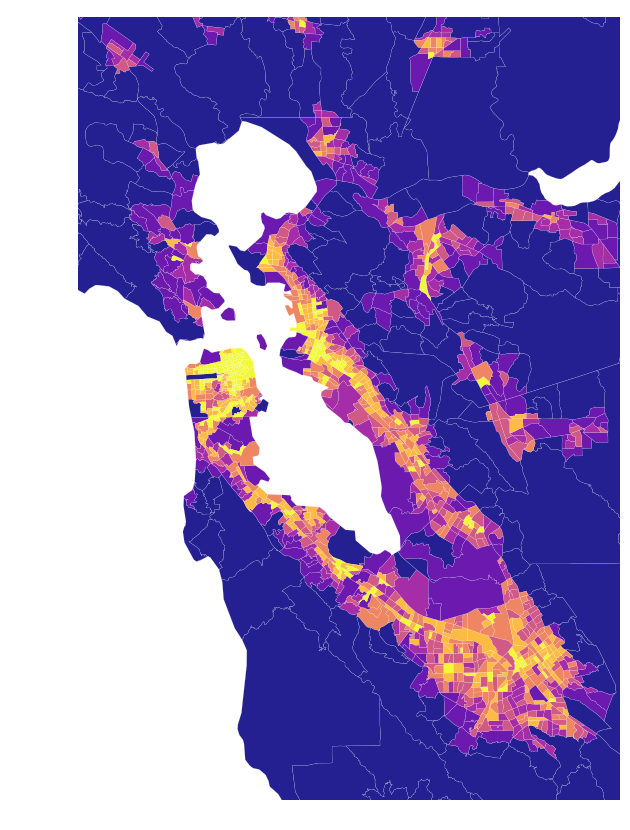

In [241]:
# set aspect ratio of plotting figure using custom projected unit boundaries
width = 7
left, bottom, right, top = (525000, 4110000, 615000, 4240000)
ratio = float(top-bottom)/(right-left)
fig, ax = plt.subplots(figsize=(width, width*ratio))

# extract each polygon as a descartes patch, and add to a matplotlib patch collection...
patches = []
facecolors = []
for _, row in gdf.iterrows():
    geometry = row['geometry']
    facecolor = row['facecolor']
    if isinstance(geometry, Polygon):
        patches.append(PolygonPatch(geometry))
        facecolors.append(facecolor)
    elif isinstance(geometry, MultiPolygon):
        for subpolygon in geometry: #if geometry is multipolygon, 
            #go through each constituent subpolygon
            patches.append(PolygonPatch(subpolygon))
            facecolors.append(facecolor)
            
pc = PatchCollection(patches, facecolors=facecolors, alpha=0.9,edgecolor='white', linewidth = 0.1)
ax.add_collection(pc)

# set the figure bounds
ax.set_xlim((left, right))
ax.set_ylim((bottom, top))
ax.set_axis_off()
fig.savefig(filename='map', dpi=100)
plt.show()

## Save data as GeoJSON for leaflet web map

In [242]:
# retain useful columns, save density as int, then re-project back to lat-long
gdf_save = gdf.reset_index()[['geometry', 'daytime_density', 'bin']]
gdf_save['daytime_density'] = gdf_save['daytime_density'].astype(int)
gdf_save = gdf_save.to_crs(epsg=epsg_latlng)

In [243]:
# dump gdf to geojson string
geojson = gdf_save.to_json(separators=(',', ':'), indent=None)

In [244]:
os.system("mkdir leaflet")

256

In [245]:
# save the geojson string to a file
output_filename = 'leaflet/geojson.js'
with open(output_filename, 'w') as output_file:
    output_file.write('var dataset = {};'.format(geojson))

In [246]:
# convert our mpl RGBa colors to a list of hex colors to use in leaflet js map
def rgb_color_list_to_hex(color_list):
    color_list_rgb = [[int(x*255) for x in c[0:3]] for c in color_list]
    return ['#{:02X}{:02X}{:02X}'.format(rgb[0], rgb[1], rgb[2]) 
            for rgb in color_list_rgb]
rgb_color_list_to_hex(bin_colors)

['#0C0786', '#5C00A5', '#9B179E', '#CB4777', '#EC7853', '#FDB32E', '#EFF821']

# BONUS: can you make the same map for NYC area?